In [3]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import utils as sk_utils
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

from IPython.display import clear_output
clear_output()
print(tf.__version__)

2.14.0


In [4]:
# Directory containing the images
train_images_path = "dataset/bdd100k_seg/bdd100k/seg/images/train/*.jpg"
train_masks_path = "dataset/bdd100k_seg/bdd100k/seg/labels/train/*.png"
val_images_path = "dataset/bdd100k_seg/bdd100k/seg/images/val/*.jpg"
val_masks_path = "dataset/bdd100k_seg/bdd100k/seg/labels/val/*.png"

In [5]:
import glob
image_size = (192, 256)

# 이미지를 불러오고 전처리하는 함수
def load_image(file_path, is_x=False):
    # tf.io.read_file을 사용하여 이미지 파일을 읽음
    image = tf.io.read_file(file_path)
    # 이미지를 텐서로 디코드함
    image = tf.image.decode_image(image)
    
    if is_x:
        # tf.image.resize를 사용하여 원하는 크기로 이미지를 리사이즈함. 여기서는 Lanczos3 메소드를 사용
        image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.LANCZOS3)
        image = image / 255.0  # 이미지를 정규화함(0~1 사이의 값으로 변환)
    else:
        # 'nearest' 메소드를 사용하여 원하는 크기로 이미지를 리사이즈함. 이때는 antialias=True 옵션을 사용
        image = tf.image.resize(image, image_size, method='nearest', antialias=True)
    return image


In [6]:
# 훈련 데이터셋을 불러옴

# 이미지 파일 경로의 목록을 얻음
image_paths = sorted(glob.glob(train_images_path))
mask_paths = sorted(glob.glob(train_masks_path))

# image_paths와 mask_paths를 무작위로 섞음
image_paths, mask_paths = sk_utils.shuffle(image_paths, mask_paths, random_state=42)

# 불러온 이미지를 저장할 리스트를 생성
X_train = []
Y_train = []

# 데이터셋의 각 이미지 경로에 load_image 함수를 적용
for x, y in zip(image_paths, mask_paths):
    X_train.append(load_image(x, True))  # 이미지를 불러와서 전처리한 후 X_train에 추가
    Y_train.append(load_image(y))  # 마스크 이미지를 불러와서 전처리한 후 Y_train에 추가
    if len(X_train) % 500 == 0:
        print(len(X_train), '개 데이터 포인트가 로드되었습니다!')
else:
    print(len(X_train), '개의 데이터 포인트가 총 로드되었습니다!')

# 리스트를 NumPy 배열로 변환
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# 255는 알 수 없는 객체를 나타냄
Y_train[Y_train == 255] = 19


500 data points loaded!
1000 data points loaded!
1500 data points loaded!
2000 data points loaded!
2500 data points loaded!
3000 data points loaded!
3500 data points loaded!
4000 data points loaded!
4500 data points loaded!
5000 data points loaded!
5500 data points loaded!
6000 data points loaded!
6500 data points loaded!
7000 data points loaded!
7000 data points loaded in total!


In [7]:
# 검증 데이터셋을 불러옴 (1000개의 관측치)

# 이미지 파일 경로의 목록을 얻음
image_paths = sorted(glob.glob(val_images_path))
mask_paths = sorted(glob.glob(val_masks_path))

# image_paths와 mask_paths를 무작위로 섞음
image_paths, mask_paths = sk_utils.shuffle(image_paths, mask_paths, random_state=42)

# 불러온 이미지를 저장할 리스트를 생성
X_val = []
Y_val = []

# 데이터셋의 각 이미지 경로에 load_image 함수를 적용
for x, y in zip(image_paths, mask_paths):
    X_val.append(load_image(x, True))  # 이미지를 불러와서 전처리한 후 X_val에 추가
    Y_val.append(load_image(y))  # 마스크 이미지를 불러와서 전처리한 후 Y_val에 추가
    if len(X_val) == 500:
        print(len(X_val), '개 데이터 포인트가 로드되었습니다!')
else:
    print(len(X_val), '개의 데이터 포인트가 총 로드되었습니다!')

# 리스트를 NumPy 배열로 변환
X_val = np.array(X_val)
Y_val = np.array(Y_val)
# 255는 알 수 없는 객체를 나타냄
Y_val[Y_val == 255] = 19


500 data points loaded!
1000 data points loaded in total!


In [8]:
print('X train:', X_train.shape)
print('Y train:', Y_train.shape)
print('X val:', X_val.shape)
print('Y val:', Y_val.shape)

X train: (7000, 192, 256, 3)
Y train: (7000, 192, 256, 1)
X val: (1000, 192, 256, 3)
Y val: (1000, 192, 256, 1)


In [9]:
# 유틸리티 함수들

import numpy as np
import matplotlib.pyplot as plt

# 각 클래스에 대한 색상을 정의하는 딕셔너리
color_dict = {
    0: (0.7, 0.7, 0.7),     # 도로 - 회색
    1:  (0.9, 0.9, 0.2),     # 보도 - 연한 노랑
    2: (1.0, 0.4980392156862745, 0.054901960784313725),
    3: (1.0, 0.7333333333333333, 0.47058823529411764),
    4: (0.8, 0.5, 0.1),  # 울타리 - 녹슨 오렌지
    5: (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
    6: (0.325, 0.196, 0.361),
    7: (1.0, 0.596078431372549, 0.5882352941176471),
    8:  (0.2, 0.6, 0.2),     # 식물 - 녹색
    9: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
    10: (0.5, 0.7, 1.0),     # 하늘 - 연한 파랑
    11: (1.0, 0.0, 0.0), # 사람 - 빨강
    12: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    13: (0.0, 0.0, 1.0),  # 차 - 파랑
    14: (0.0, 0.0, 1.0),  # 트랙 - 파랑
    15: (0.0, 0.0, 1.0),  # 버스 - 파랑
    16: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
    17: (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
    18: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    19: (0, 0, 0) # 알 수 없음 - 검정
}

# 이미지를 색상화하는 함수
def colorize_image(image, color_dict):
    # 불필요한 차원 제거
    image = np.squeeze(image)
    # 색상 딕셔너리를 사용하여 색상화된 이미지 생성
    colored_image = np.zeros((image.shape[0], image.shape[1], 3))

    # 각 픽셀 값에 대해 색상 딕셔너리에서 색상을 찾아 이미지에 적용
    for pixel_value, color in color_dict.items():
        colored_image[image == pixel_value] = color

    # 이미지를 8비트 부호 없는 정수로 변환
    colored_image = (colored_image * 255).astype(np.uint8)

    return colored_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


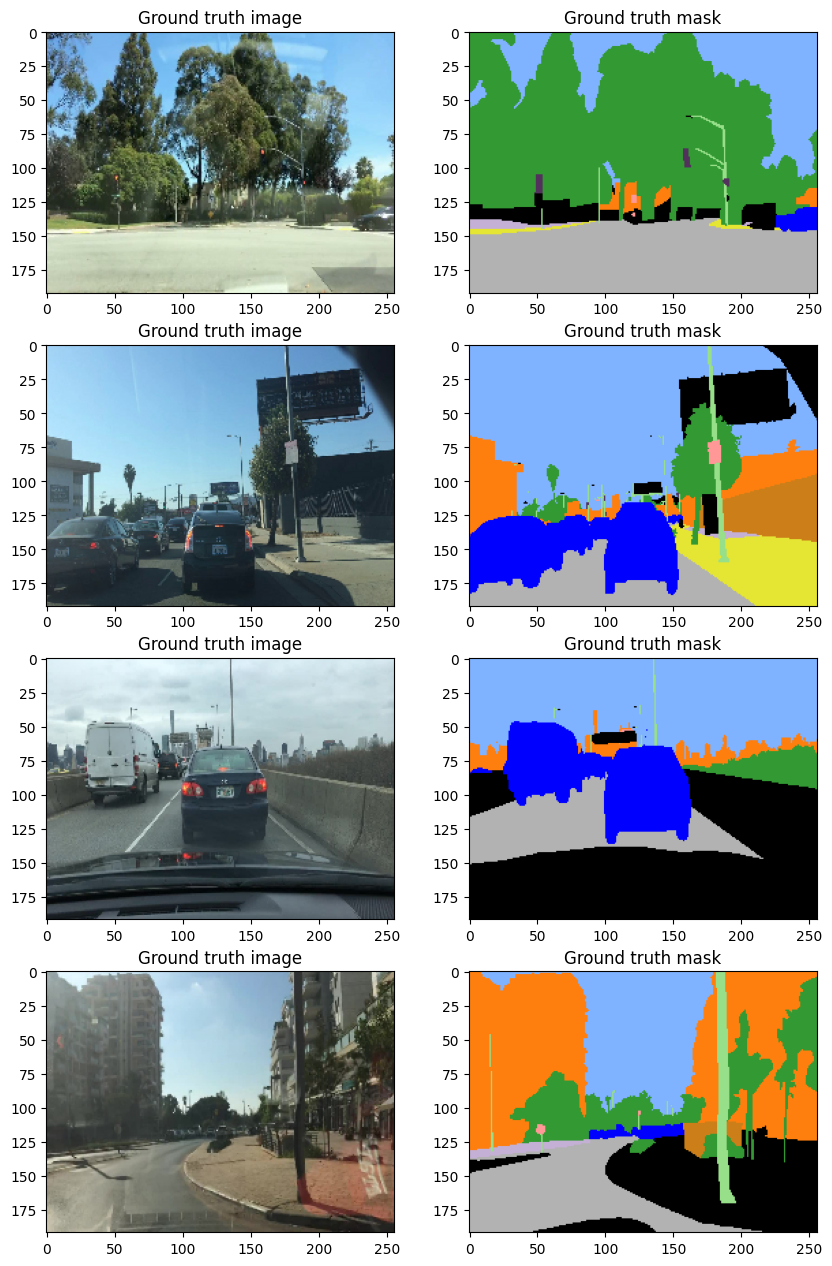

In [10]:
# 훈련 세트에서 일부 샘플 시각화
plt.figure(figsize=(10, 40)) # 그림의 크기 설정 (가로 10, 세로 40)
s, e = 80, 84  # 시작 인덱스와 종료 인덱스 설정
index = 1  # 그래프를 그릴 때 사용할 인덱스 초기화

# X_train과 Y_train에서 시작 인덱스와 종료 인덱스 사이의 데이터를 순회하며 그래프 그리기
for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)  # 10행 2열의 서브플롯에서 현재 인덱스 위치에 그래프 그리기
    plt.imshow(i)  # 이미지 i를 그래프로 표현
    plt.title('Ground truth image')  # 그래프 제목 설정 ('Ground truth image'는 '실제 이미지'를 의미합니다.)
    
    plt.subplot(10, 2, index+1)  # 같은 방식으로 마스크 이미지에 대한 그래프를 그립니다.
    plt.imshow(colorize_image(j, color_dict))  # 마스크 이미지를 색깔별로 구분하여 그래프로 표현
    plt.title('Ground truth mask')  # 그래프 제목 설정 ('Ground truth mask'는 '실제 마스크 이미지'를 의미합니다.)
    
    index += 2  # 다음 그래프를 그릴 위치를 위해 인덱스를 2씩 증가시킵니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


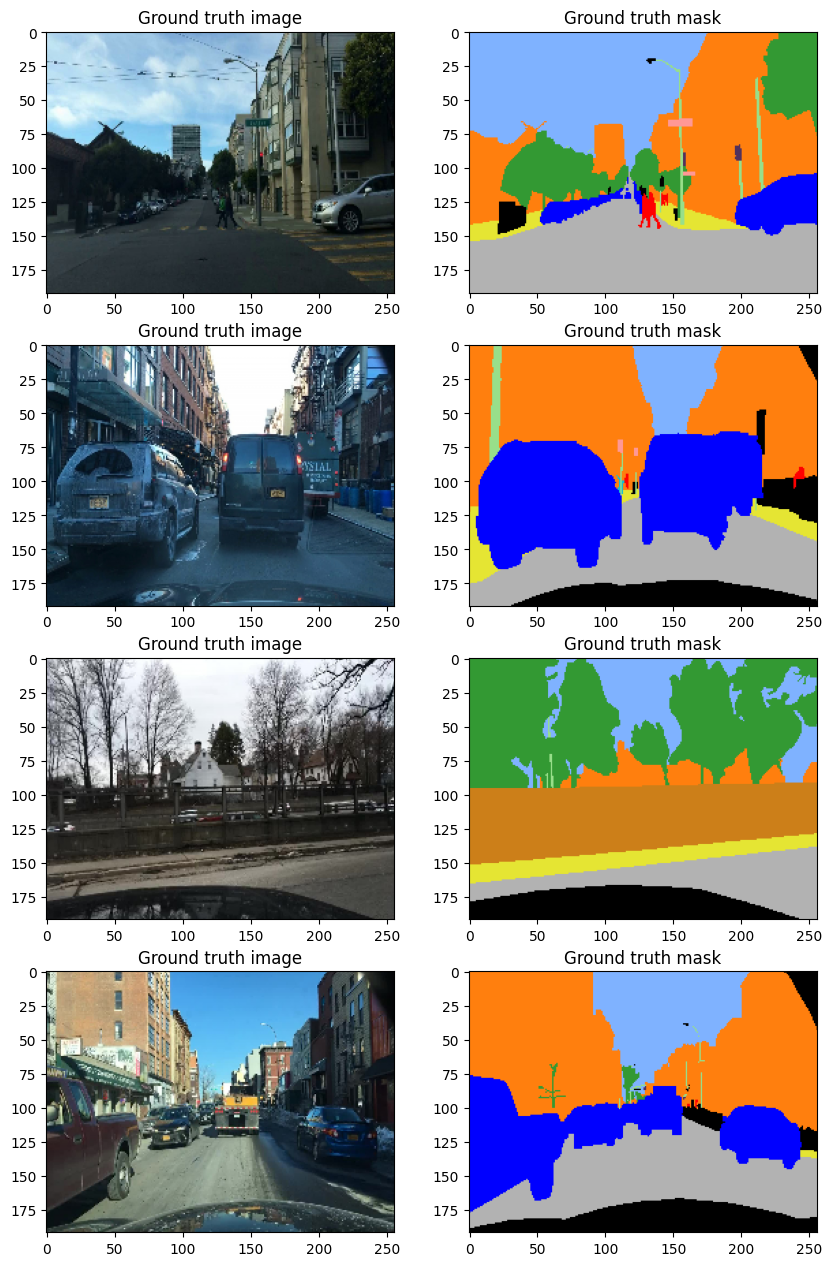

In [11]:
# 검증 세트에서 일부 샘플 시각화
plt.figure(figsize=(10, 40)) # 그림의 크기 설정 (가로 10, 세로 40)
s, e = 10, 14  # 시작 인덱스와 종료 인덱스 설정
index = 1  # 그래프를 그릴 때 사용할 인덱스 초기화

# X_val과 Y_val에서 시작 인덱스와 종료 인덱스 사이의 데이터를 순회하며 그래프 그리기
for i, j in zip(X_val[s:e], Y_val[s:e]):
    plt.subplot(10, 2, index)  # 10행 2열의 서브플롯에서 현재 인덱스 위치에 그래프 그리기
    plt.imshow(i)  # 이미지 i를 그래프로 표현
    plt.title('Ground truth image')  # 그래프 제목 설정 ('Ground truth image'는 '실제 이미지'를 의미합니다.)
    
    plt.subplot(10, 2, index+1)  # 같은 방식으로 마스크 이미지에 대한 그래프를 그립니다.
    plt.imshow(colorize_image(j, color_dict))  # 마스크 이미지를 색깔별로 구분하여 그래프로 표현
    plt.title('Ground truth mask')  # 그래프 제목 설정 ('Ground truth mask'는 '실제 마스크 이미지'를 의미합니다.)
    
    index += 2  # 다음 그래프를 그릴 위치를 위해 인덱스를 2씩 증가시킵니다.

In [12]:
# free the RAM by collecting the garbage
import gc
gc.collect()

48043

In [13]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate
from keras.models import Model

def unet(input_size=(*image_size,3)):
    inputs = Input(input_size)
    
    # Encoder
    # 첫 번째 인코딩 블록
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # 두 번째 인코딩 블록
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # 세 번째 인코딩 블록
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # 네 번째 인코딩 블록
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Decoder
    # 중앙의 컨볼루션 블록
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # 첫 번째 디코딩 블록
    up6 = Conv2DTranspose(512, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    # 두 번째 디코딩 블록
    up7 = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    # 세 번째 디코딩 블록
    up8 = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    # 네 번째 디코딩 블록
    up9 = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # 최종 컨볼루션 레이어
    outputs = Conv2D(20, 1, activation='softmax')(conv9)
    
    # 모델 생성
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet()

# Compile the model
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 192, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 96, 128, 64)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [14]:
model = tf.keras.models.load_model('asad_epoch5.h5')
# 최적화 알고리즘: Adam, 학습률: 0.0001, 손실 함수로: SparseCategoricalCrossentropy, 평가 지표로: 정확도
model.compile(optimizer=keras.optimizers.Adam(0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 192, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 96, 128, 64)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [26]:
# # train the model
# epochs = 1
# batch_size = 16

# model.fit(
#     X_train,
#     Y_train,    
#     epochs=epochs,
#     validation_data=(X_val, Y_val),
#     batch_size=batch_size
# )

438/438 [==============================] - 7971s 18s/step - loss: 1.3721 - accuracy: 0.5561 - val_loss: 1.0059 - val_accuracy: 0.6807


In [15]:
Y_pred = model.predict(X_val)  # 검증 데이터셋(X_val)에 대해 모델을 이용해서 예측을 수행하고, 그 결과를 Y_pred에 저장합니다.

Y_pred = np.argmax(Y_pred, axis=-1).reshape(-1, *image_size, 1)  
# 예측 결과(Y_pred) 중에서 마지막 차원(-1)을 기준으로 가장 큰 값의 인덱스를 반환합니다. 
# 이는 각 픽셀이 어떤 클래스에 속하는지 결정하는 과정입니다.
# reshape 함수를 이용해서 예측 결과의 형태를 변경합니다. -1은 남은 차원을 모두 채우라는 의미이고, *image_size는 원래 이미지의 크기를 의미합니다. 
# 마지막의 1은 채널 수를 의미하며, 이 경우에는 1개의 채널을 가집니다.


32/32 [==============================] - 175s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


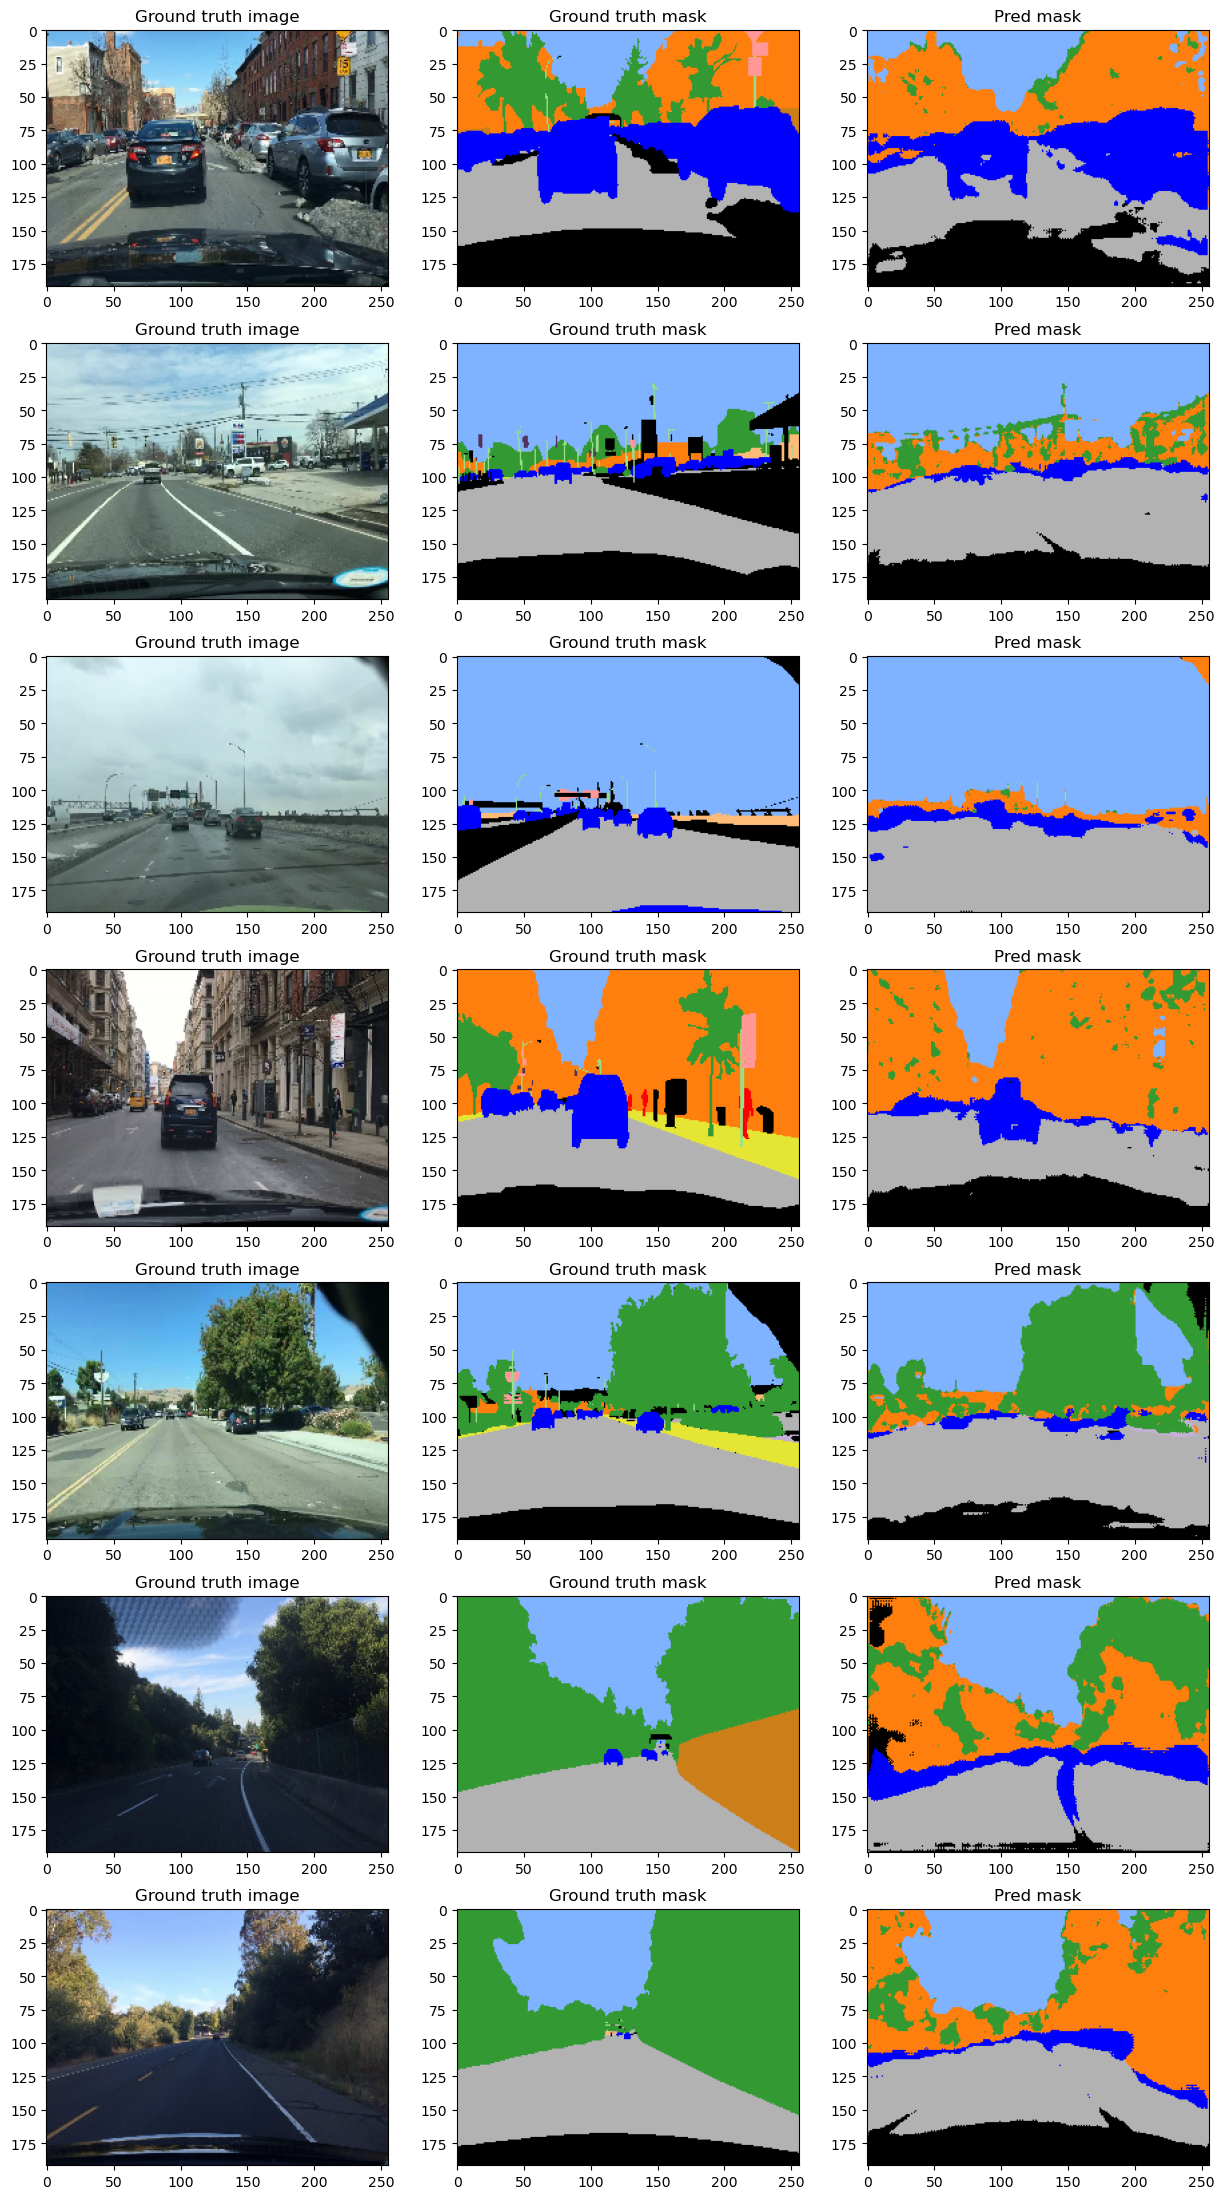

In [28]:
# 검증 세트에서 일부 결과 시각화
plt.figure(figsize=(15, 40))  # 그림의 크기 설정 (가로 15, 세로 40)
s, e = 1, 8  # 시작 인덱스와 종료 인덱스 설정
index = 1  # 그래프를 그릴 때 사용할 인덱스 초기화

# X_val, Y_pred, Y_val에서 시작 인덱스와 종료 인덱스 사이의 데이터를 순회하며 그래프 그리기
for i, j, k in zip(X_val[s:e], Y_pred[s:e], Y_val[s:e]):

    # 이 이미지들을 파일로도 작성합니다.
    cv2.imwrite(f'./out/img-{index}.jpg', i)  # 원본 이미지 i를 'out' 폴더에 'img-{index}.jpg' 이름으로 저장
    cv2.imwrite(f'./out/pred-{index}.png', j)  # 예측 마스크 j를 'out' 폴더에 'pred-{index}.png' 이름으로 저장
    cv2.imwrite(f'./out/ground-{index}.png', k)  # 실제 마스크 k를 'out' 폴더에 'ground-{index}.png' 이름으로 저장
    
    plt.subplot(10, 3, index)  # 10행 3열의 서브플롯에서 현재 인덱스 위치에 그래프 그리기
    plt.imshow(i)  # 이미지 i를 그래프로 표현
    plt.title('Ground truth image')  # 그래프 제목 설정 ('Ground truth image'는 '실제 이미지'를 의미합니다.)
    
    plt.subplot(10, 3, index+1)  # 같은 방식으로 실제 마스크 이미지에 대한 그래프를 그립니다.
    plt.imshow(colorize_image(k, color_dict))  # 마스크 이미지를 색깔별로 구분하여 그래프로 표현
    plt.title('Ground truth mask')  # 그래프 제목 설정 ('Ground truth mask'는 '실제 마스크 이미지'를 의미합니다.)
    
    plt.subplot(10, 3, index+2)  # 같은 방식으로 예측 마스크 이미지에 대한 그래프를 그립니다.
    plt.imshow(colorize_image(j, color_dict))  # 예측 마스크 이미지를 색깔별로 구분하여 그래프로 표현
    plt.title('Pred mask')  # 그래프 제목 설정 ('Pred mask'는 '예측 마스크 이미지'를 의미합니다.)
    
    index += 3  # 다음 그래프를 그릴 위치를 위해 인덱스를 3씩 증가시킵니다.


In [17]:
from tensorflow.keras.metrics import MeanIoU, Accuracy  # MeanIoU와 Accuracy 메트릭을 가져옵니다.

num_classes = 20  # 클래스의 수를 설정합니다.

def compute_metrics(gt_masks, pred_masks):  # 실제 마스크와 예측 마스크를 인자로 받는 함수를 정의합니다.
    # 마스크를 (배치 크기, 높이, 너비) 형태로 재구성합니다.
    gt_masks_reshaped = tf.reshape(gt_masks, [-1, tf.shape(gt_masks)[-1]])
    pred_masks_reshaped = tf.reshape(pred_masks, [-1, tf.shape(pred_masks)[-1]])

    # 정확도를 계산합니다.
    accuracy_metric = Accuracy()  # Accuracy 메트릭을 생성합니다.
    accuracy_metric.update_state(gt_masks_reshaped, pred_masks_reshaped)  # 메트릭을 업데이트합니다.
    accuracy = accuracy_metric.result().numpy()  # 메트릭의 결과를 numpy 배열로 변환합니다.

    # 평균 IoU를 계산합니다.
    iou_metric = MeanIoU(num_classes=num_classes)  # MeanIoU 메트릭을 생성합니다.
    iou_metric.update_state(gt_masks_reshaped, pred_masks_reshaped)  # 메트릭을 업데이트합니다.
    miou = iou_metric.result().numpy()  # 메트릭의 결과를 numpy 배열로 변환합니다.

    return accuracy, miou  # 정확도와 평균 IoU를 반환합니다.

# 함수 사용 예시
# Y_val와 Y_pred로부터 정확도와 평균 IoU를 계산합니다.
accuracy, miou = compute_metrics(Y_val, Y_pred)

# 메트릭 값 출력
print("Accuracy:", accuracy)
print("Mean IoU:", miou)


Accuracy: 0.80463874
Mean IoU: 0.25170463


In [30]:
# save the model
model.save('asad_epoch5.h5')

c:\Users\CS3-36\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
